Author: *Davide Cittaro*   
First compiled: *February 9, 2018.*

## Cell-Cycle Scoring and Regression

This is a _Scanpy_ demo that shows how to regress cell cycle effect, following the approach showed in [Seurat's vignette](http://satijalab.org/seurat/cell_cycle_vignette.html#assign-cell-cycle-scores). As for the R example, toy dataset consists of murine hematopoietic progenitors from [Nestorowa et al., Blood 2016](https://doi.org/10.1182/blood-2016-05-716480). The files of the Seurat tutorial - used here for reasons of benchmarking - can be downloaded [here](https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1). A more recent version of the dataset can be downloaded [here](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_log2_transformed_counts.txt.gz).

In [1]:
import scanpy.api as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0.4.3+7.g2bc93a6 on 2018-02-15 09:34.
Dependencies: numpy==1.14.0 scipy==1.0.0 pandas==0.21.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


Load data

In [2]:
adata = sc.read_csv('./data/nestorawa_forcellcycle_expressionMatrix.txt', delimiter='\t').T

Load cell cycle genes defined in [Tirosh et al, 2015](https://doi.org/10.1126/science.aad0501). It is a list of 97 genes, represented by their gene symbol. The list here is for humans, in case of alternate organism, a list of ortologues should be compiled.
There are major differences in the way _Scanpy_ and _Seurat_ manage data, in particular we need to filter out cell cycle genes that are not present in our dataset to avoid errors.

In [3]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

Here we define two lists, genes associated to the S phase and genes associated to the G2M phase

In [4]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

Standard filters applied. Note that we do not extract variable genes and work on the whole dataset, instead. This is because, for this demo, almost 70 cell cycle genes would not be scored as variable. Cell cycle scoring on ~20 genes is ineffective. 

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00.148): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)


Log-transformation of data and scaling should always be performed before scoring

In [6]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

We here perform cell cycle scoring. The function is actually a wrapper to `sc.tl.score_gene_list`, which is launched twice, to score separately S and G2M phases. Both `sc.tl.score_gene_list` and `sc.tl.score_cell_cycle_genes` are a port from _Seurat_ and are supposed to work in a very similar way. 
To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list.
Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [7]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:01:16.410) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:01:04.165) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


Here comes another difference from _Seurat_. The R package stores raw data, scaled data and variable genes information in separate slots, _Scanpy_ instead keeps only one snapshot of the data. This implies that PCA is always calculated on the entire dataset. In order to calculate PCA reduction using only a subset of genes (like `cell_cycle_genes`), a trick should be used.
Basically we create a dummy object to store information of PCA projection, which is then reincorporated into original dataset.

... storing phase as categorical type
    access categories as adata.obs['phase'].cat.categories


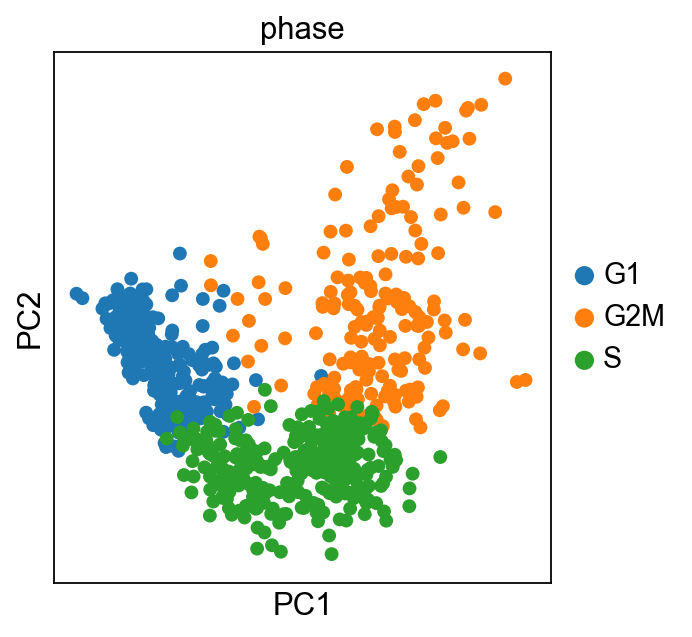

In [8]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

As in the original vignette, cells can be easily separated by their cell cycle status when cell cycle genes are used.
Now we can regress out both S score and G2M score.

In [9]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score']
finished (0:00:43.387)
--> after `sc.pp.regress_out`, consider rescaling the adata using `sc.pp.scale`


Finally, we reproject dataset using cell cycle genes again. Since we regressed the scores, no effect of cell cycle is now evident.

... storing phase as categorical type
    access categories as adata.obs['phase'].cat.categories


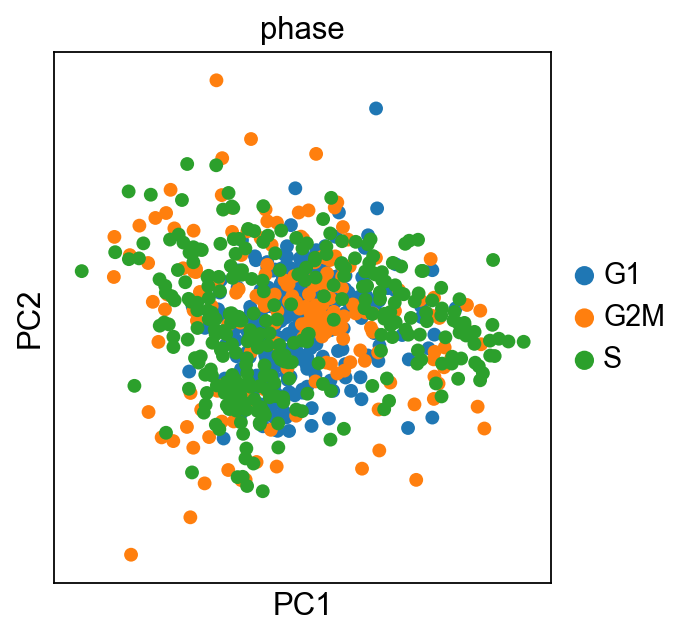

In [10]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')